# Performance Analysis of Different Versions

This notebook walks through the complete workflow for:
1. Loading and cleaning benchmarking data
2. Computing summary statistics (min, mean, max) by version and input size
3. Visualizing performance per version using bar plots with error bars
4. Exploring different axis scalings (zoom, log–log)
5. Comparing versions via overlapping average-time curves, relative performance, and percent difference
6. Demonstrating a broken y-axis to handle widely separated regions

1. Import necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## 2. Load and Inspect Data
- Read the `results.csv` file, stripping any accidental spaces in column names.
- Display the first few rows and data types.

Load CSV and normalize column names

In [ ]:
csv_path = 'results.csv'
df = pd.read_csv(csv_path, sep=',', skipinitialspace=True)
df.columns = df.columns.str.strip()

print(df.head())
print(df.dtypes)

## 3. Ensure Numeric Types
Convert `size` and `time` to numeric (raises an error if conversion fails).

In [4]:
df['size'] = pd.to_numeric(df['size'], errors='raise')
df['time'] = pd.to_numeric(df['time'], errors='raise')

## 4. Compute Summary Statistics
Group by `version` and `size` to compute the minimum, average, and maximum times.

In [5]:
summary = (
    df
    .groupby(['version', 'size'])['time']
    .agg(min_time='min', avg_time='mean', max_time='max')
    .reset_index()
)
summary.head()


,version,size,min_time,avg_time,max_time
0,1,10,0.000036,0.000045,0.000063
1,1,100,0.000063,0.000073,0.000111
2,1,500,0.000177,0.000190,0.000238
3,1,1000,0.000331,0.000378,0.000567
4,1,10000,0.003144,0.003563,0.004327


## 5. Bar Plot with Error Bars and Overlayed Lines
For each version, draw:
- A bar at each size showing the average time, with error bars for `[avg - min, max - avg]`.
- Dashed lines for min and max, and a solid line for the mean.

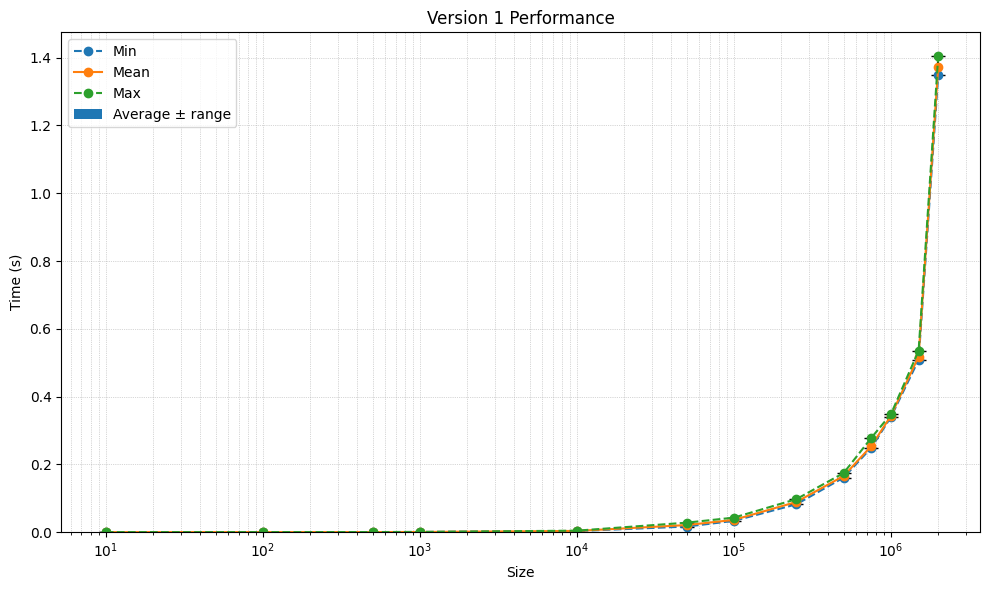

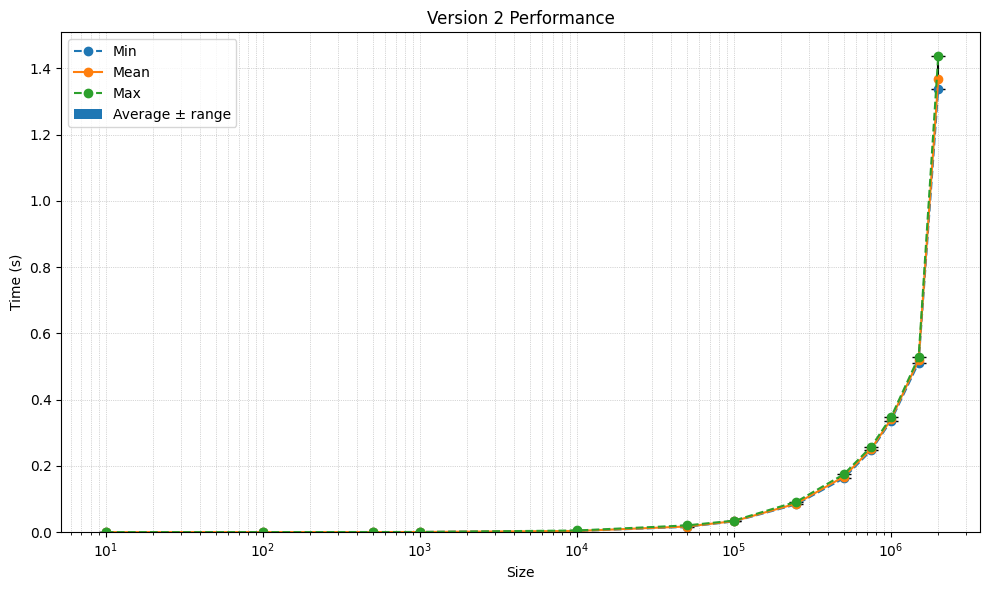

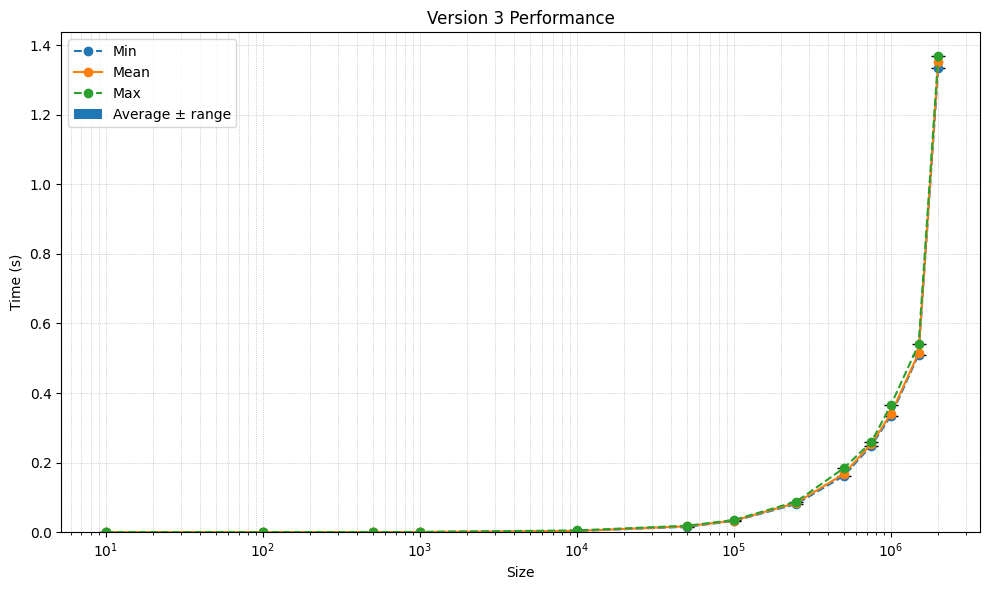

In [6]:
for version, grp in summary.groupby('version'):
    fig, ax = plt.subplots(figsize=(10, 6))
    sizes = grp['size']
    mins   = grp['min_time']
    avgs   = grp['avg_time']
    maxs   = grp['max_time']

    # Calculate error bars
    err_low  = avgs - mins
    err_high = maxs - avgs

    # Bar plot
    ax.bar(sizes, avgs,
           yerr=[err_low, err_high],
           capsize=5,
           label='Average ± range')
    # Overlay lines
    ax.plot(sizes, mins,  marker='o', linestyle='--', label='Min')
    ax.plot(sizes, avgs,  marker='o',               label='Mean')
    ax.plot(sizes, maxs,  marker='o', linestyle='--', label='Max')

    ax.set_xscale('log')
    ax.set_xlabel('Size')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Version {version} Performance')
    ax.legend()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()


## 6. Zoomed-in View on Small-time Region
Limit the y-axis to focus on the sub-0.005 s region for Version 1.


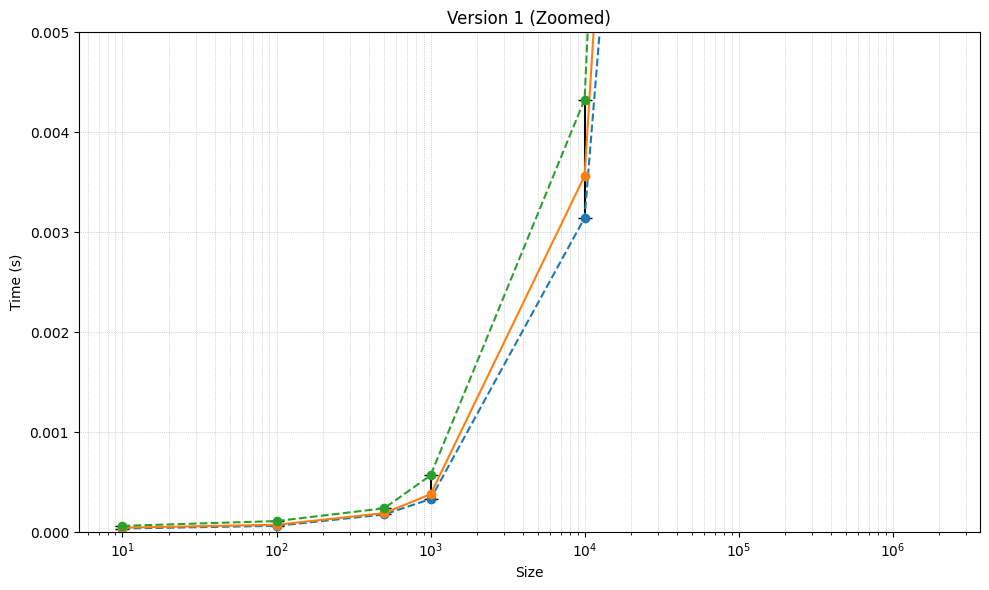

In [7]:
v1 = summary[summary['version'] == 1]
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(v1['size'], v1['avg_time'],
       yerr=[v1['avg_time'] - v1['min_time'], v1['max_time'] - v1['avg_time']],
       capsize=5)
ax.plot(v1['size'], v1['min_time'], marker='o', linestyle='--')
ax.plot(v1['size'], v1['avg_time'], marker='o')
ax.plot(v1['size'], v1['max_time'], marker='o', linestyle='--')

ax.set_xscale('log')
ax.set_ylim(0, 0.005)  # zoom in
ax.set_xlabel('Size')
ax.set_ylabel('Time (s)')
ax.set_title('Version 1 (Zoomed)')
ax.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. Log–Log Plot for All Versions
Use log scaling on both axes to highlight power-law trends.


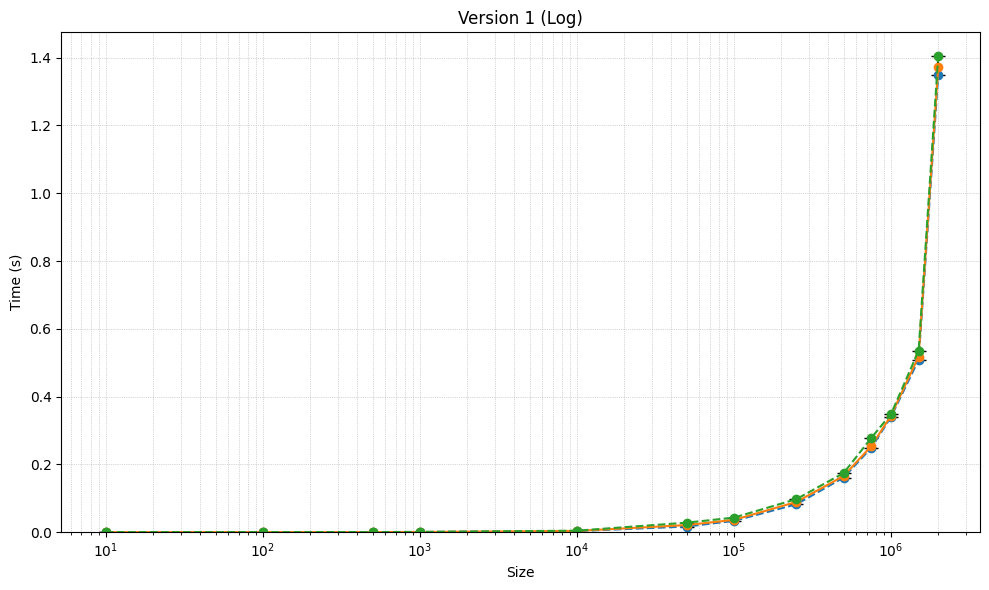

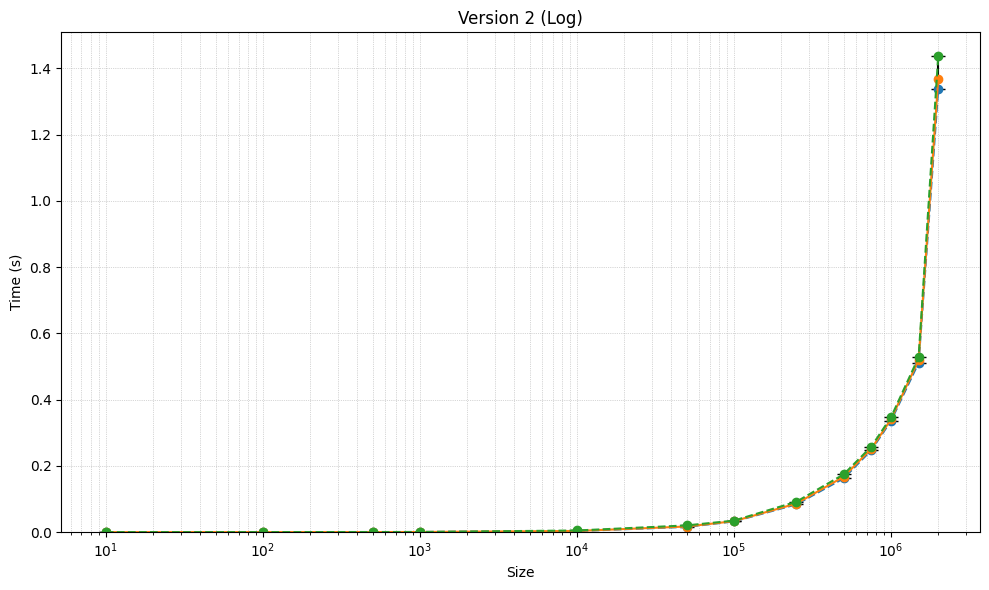

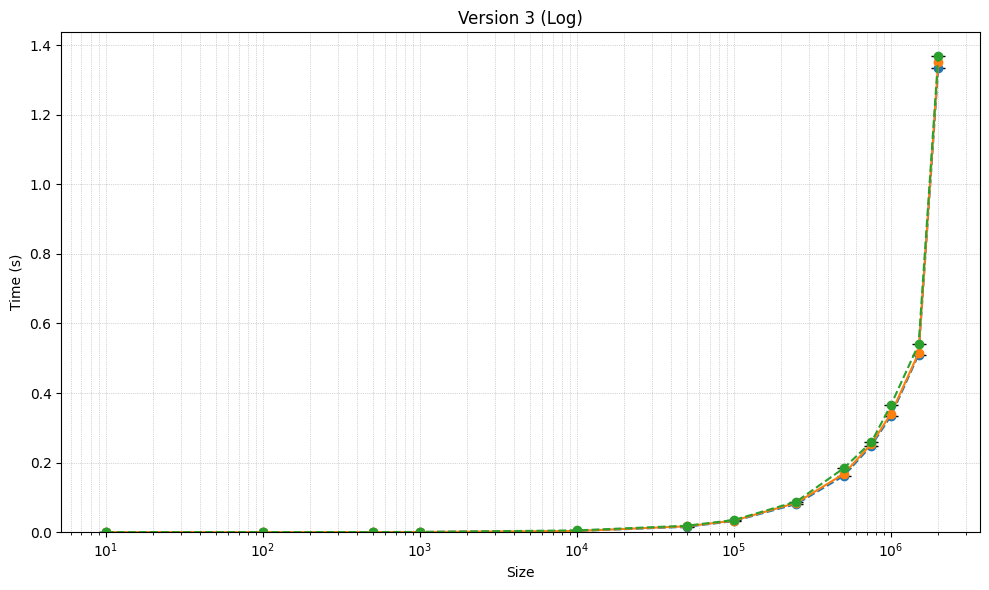

In [10]:
for version, grp in summary.groupby('version'):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(grp['size'], grp['avg_time'],
           yerr=[grp['avg_time'] - grp['min_time'], grp['max_time'] - grp['avg_time']],
           capsize=5)
    ax.plot(grp['size'], grp['min_time'], marker='o', linestyle='--')
    ax.plot(grp['size'], grp['avg_time'], marker='o')
    ax.plot(grp['size'], grp['max_time'], marker='o', linestyle='--')

    ax.set_xscale('log')
    ax.set_xlabel('Size')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Version {version} (Log)')
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:


# %% [markdown]
# ## 8. Overlapping Average-Time Curves
# Compare average performance of all versions on one plot.

# %%
pivot = summary.pivot(index='size', columns='version', values='avg_time')
fig, ax = plt.subplots(figsize=(10, 6))
for version in pivot.columns:
    ax.plot(pivot.index, pivot[version], marker='o', linewidth=2, label=f'Version {version}')
ax.set_xscale('log')
ax.set_xlabel('Size')
ax.set_ylabel('Average Time (s)')
ax.set_title('Average Execution Time vs. Size (All Versions)')
ax.legend(title='Version')
ax.grid(which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Relative Performance Normalized to Version 1
# Plot fold-change relative to Version 1 at each size.

# %%
norm = pivot.div(pivot[1], axis=0)
fig, ax = plt.subplots(figsize=(10,6))
for v in norm.columns:
    ax.plot(norm.index, norm[v], marker='o', label=f'Version {v}')
ax.set_xscale('log')
ax.set_xlabel('Size')
ax.set_ylabel('Relative Time (vs v1)')
ax.set_title('Normalized Average Time (Version i / Version 1)')
ax.legend(title='Version')
ax.grid(which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Percent Difference from Version 1
# Plot percentage difference in average time from Version 1.

# %%
pct = (pivot.subtract(pivot[1], axis=0)
        .div(pivot[1], axis=0)
        * 100)
fig, ax = plt.subplots(figsize=(10,6))
for v in pct.columns:
    ax.plot(pct.index, pct[v], marker='o', label=f'Version {v}')
ax.set_xscale('log')
ax.set_xlabel('Size')
ax.set_ylabel('Percent Difference from v1 (%)')
ax.set_title('Percent Difference of Average Time vs Version 1')
ax.legend(title='Version')
ax.grid(which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 11. Broken Y-Axis to Handle Wide Ranges
# Show two y-axis panels: zoomed small-time region below ~0.01 s, and expanded above.

# %%
from matplotlib import gridspec

fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

for v in pivot.columns:
    ax_top.plot(pivot.index, pivot[v], marker='o', label=f'Version {v}')
    ax_bot.plot(pivot.index, pivot[v], marker='o')

# Set y-limits
max_val = pivot.max().max()
top_cut = max_val * 0.5
bot_cut = pivot[pivot.index < 10000].max().max() * 1.1
ax_top.set_ylim(top_cut, max_val * 1.05)
ax_bot.set_ylim(0, bot_cut)

# Hide connecting spines and ticks
aq_top.spines['bottom'].set_visible(False)
ax_bot.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)

ax_bot.set_xscale('log')
ax_bot.set_xlabel('Size')
ax_top.set_ylabel('Time (s)')
ax_bot.set_ylabel('Time (s)')
ax_top.legend(title='Version')
ax_bot.grid(which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()
